# <span style="color:#900C3F"> Laboratorio di Simulazione Numerica</span>

# <span style="color: #C70039 "> Esercitazione 6</span>

### <span style="color: #FF5733 "> Esercizio 06.1</span>

L'esercizio chiede di simulare un modello di Ising monodimensionale. Se si considera solo l'interazione a primi vicini, l'Hamiltoniana del sistema (considerando  $\mu_B=1$ e $k_B=1$), si scrive come: $H = -J\sum_{i=1}^N s_i s_{i+1}-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) $, dove $s_{i}$ può valere 1 (spin up) o -1 (spin down), $J>0$ e si guarda il sistema di spin in Pbc di modo che $s_{N+1} = s_{1}$.  
La funzione di partizione del sistema può essere calcolata in modo esatto: $Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N$ e conoscendo Z si possono calcolare in modo esatto le quantità termodinamiche di interesse:  
- l'energia interna per spin: $\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}=-J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)$, con $h=0$
- la capacità termica: $ C(N,T) = k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)=$  
$$k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\},
$$ con $h=0$
- la magnetizzazione: $M(N,T,h)= \left\langle \sum_{i=1,N}s_i \right\rangle=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]$ , con $h\not=0$ 
- la suscettività magnetica: $\chi(N,T) = \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right]=\beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)$ , con $h=0$  

Tramite la simulazione ho potuto campionare le quantità termodinamiche di interesse attraverso la loro prima definizione riportata (cioè come valori medi) e ho potuto poi confrontare il risultato ottenuto con il valor teorico (calcolabile appunto perchè nel caso 1D con interazione a primi vicini si riesce a calcolare in modo esatto la funzione di partizione Z).  
In particolare ho aggiunto al codice fornitoci la possibilità ripartire dalla configurazione a cui il sistema era arrivato con la simulazione precedente. Per farlo ho aggiunto la variabile *restart*: quando questa vale 0, la configurazione iniziale viene costruita scegliendo ciascuno a caso (probabilità $1/2$ di essere up e $1/2$ di essere down) e la configurazione finale viene scritta su un file di output. Quando *restart* vale 1, la configurazione iniziale viene letta da questo file di output. L'utilizzo della variabile *restart* è importante per la fase di equilibrazione del sistema, infatti la configurazione casuale iniziale non è la configurazione di equilibrio del sistema di spin alla temperatura desiderata (che viene letta da file di input); è importante quindi fare qualche passo di equilibrazione per portate il sistema all'equilibrio e non dimenticare poi la configurazione raggiunta, prima di iniziare la vera e propria simulazione.  
Ho aggiunto al codice la possibilità di campionare usando l'algoritmo di Metropolis o quello di Gibbs.  

**Sampling alla Gibbs**:  
l'idea del campionamento alla Gibbs è la seguente: si considera, per esempio, lo stato up di uno spin $s_k$ e si calcola la quantità $p(s'_k=1)=\frac{1}{1+exp(-\beta\Delta E_{s_k=-1 \rightarrow s_k=+1})}$, cioè la probabilità che lo spin $s_k$ sia up. Si estrae poi una quantità r uniformemente distribuita tra 0 e 1 e, se $r\leq p(s'_k)$, lo spin k-esimo sarà up, altrimenti sarà down.  


Ho poi aggiunto il calcolo delle quantità richieste e implementato la loro media a blocchi. Fatta eccezione per l'energia interna, le quantità che sommo nella funzione *Accumulate()*, non hanno il significato fisico di capacità termica, magnetizzazione e suscettviità magnetica, ma solo le medie del blocco assumono il corretto significato fisico e sono quindi le quantità rilevanti.  

Per poter calcolare le quantità richieste in funzione della temperatura ho scritto il seguente script Python, che fa variare i parametri nel file di input ed esegue il codice. In particolare, per ogni valore di temperatura, viene prima eseguito una volta il codice con la variabile *restart* a zero, il numero di blocchi a 100 e il numero di step per blocco a 1000 (uno step consiste nel provare a girare una volta tutti gli spin che compongono il sistema). Ho infatti controllato "a mano" (cioè guardando i grafici delle singole quantità fisiche in funzione del blocco) che dopo circa 80 blocchi da 1000 passi ciascuno posso considerare il sistema ben equilibrato (cioè le quantità fisiche osservate si sono stabilizzate) ed eseguo 20 blocchi in più per esserne certa. Viene poi eseguito il codice con la variabile *restart* a uno, il numero di blocchi a 200 e il numero di step per blocco a 2000. Ho realizzato grafici in funzione della temperatura con 100 punti. Ho prima eseguito un ciclo sulle temperature tenendo sempre $h=0$ e poi un secondo ciclo sulle temperature con $h=0,02$, per realizzare il grafico relativo alla magnetizzazione.

In [2]:
%%time
import numpy as np
import subprocess 
import matplotlib

t=np.linspace(0.5,2.0, num=100, endpoint=True)
#Metropolis
metro_energy=np.zeros(t.size)
metro_energy_errors=np.zeros(t.size)
metro_heat_capacity=np.zeros(t.size)
metro_heat_capacity_errors=np.zeros(t.size)
metro_chi=np.zeros(t.size)
metro_chi_errors=np.zeros(t.size)
for i in range(0,t.size):
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(0)+"\n"
    lines[1]=str(t[i])+"\n"
    lines[2]=str(50)+"\n" #nspin
    lines[3]=str(1.0)+"\n" #J
    lines[4]=str(0)+"\n" #h
    lines[5]=str(1)+"\n" #1 metropolis, else Gibbs
    lines[6]=str(100)+"\n" #numero di blocchi
    lines[7]=str(1000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(1)+"\n"
    lines[6]=str(200)+"\n" #numero di blocchi
    lines[7]=str(2000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    metro_energy[i]=np.loadtxt("output.ene.0", usecols=(1), delimiter='\t', skiprows=299)
    metro_energy_errors[i]=np.loadtxt("output.ene.0", usecols=(2), delimiter='\t', skiprows=299)
    metro_heat_capacity[i]=np.loadtxt("output.heat.0", usecols=(1), delimiter='\t', skiprows=299)
    metro_heat_capacity_errors[i]=np.loadtxt("output.heat.0", usecols=(2), delimiter='\t', skiprows=299)
    metro_chi[i]=np.loadtxt("output.chi.0", usecols=(1), delimiter='\t', skiprows=299)
    metro_chi_errors[i]=np.loadtxt("output.chi.0", usecols=(2), delimiter='\t', skiprows=299)
    
metro_mag=np.zeros(t.size)
metro_mag_errors=np.zeros(t.size)

for i in range(0,t.size):
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(0)+"\n"
    lines[1]=str(t[i])+"\n"
    lines[2]=str(50)+"\n" #nspin
    lines[3]=str(1.0)+"\n" #J
    lines[4]=str(0.02)+"\n" #h
    lines[5]=str(1)+"\n" #1 metropolis, else Gibbs
    lines[6]=str(100)+"\n" #numero di blocchi
    lines[7]=str(1000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(1)+"\n"
    lines[6]=str(200)+"\n" #numero di blocchi
    lines[7]=str(2000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    metro_mag[i]=np.loadtxt("output.mag.0", usecols=(1), delimiter='\t', skiprows=299)
    metro_mag_errors[i]=np.loadtxt("output.mag.0", usecols=(2), delimiter='\t', skiprows=299)
    


CPU times: user 512 ms, sys: 924 ms, total: 1.44 s
Wall time: 7min 56s


In [3]:
#Gibbs
gibbs_energy=np.zeros(t.size)
gibbs_energy_errors=np.zeros(t.size)
gibbs_heat_capacity=np.zeros(t.size)
gibbs_heat_capacity_errors=np.zeros(t.size)
gibbs_chi=np.zeros(t.size)
gibbs_chi_errors=np.zeros(t.size)
for i in range(0,t.size):
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(0)+"\n"
    lines[1]=str(t[i])+"\n"
    lines[2]=str(50)+"\n" #nspin
    lines[3]=str(1.0)+"\n" #J
    lines[4]=str(0)+"\n" #h
    lines[5]=str(0)+"\n" #1 metropolis, else Gibbs
    lines[6]=str(100)+"\n" #numero di blocchi
    lines[7]=str(1000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(1)+"\n"
    lines[6]=str(200)+"\n" #numero di blocchi
    lines[7]=str(2000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    gibbs_energy[i]=np.loadtxt("output.ene.0", usecols=(1), delimiter='\t', skiprows=299)
    gibbs_energy_errors[i]=np.loadtxt("output.ene.0", usecols=(2), delimiter='\t', skiprows=299)
    gibbs_heat_capacity[i]=np.loadtxt("output.heat.0", usecols=(1), delimiter='\t', skiprows=299)
    gibbs_heat_capacity_errors[i]=np.loadtxt("output.heat.0", usecols=(2), delimiter='\t', skiprows=299)
    gibbs_chi[i]=np.loadtxt("output.chi.0", usecols=(1), delimiter='\t', skiprows=299)
    gibbs_chi_errors[i]=np.loadtxt("output.chi.0", usecols=(2), delimiter='\t', skiprows=299)
    
gibbs_mag=np.zeros(t.size)
gibbs_mag_errors=np.zeros(t.size)

for i in range(0,t.size):
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(0)+"\n"
    lines[1]=str(t[i])+"\n"
    lines[2]=str(50)+"\n" #nspin
    lines[3]=str(1.0)+"\n" #J
    lines[4]=str(0.02)+"\n" #h
    lines[5]=str(1)+"\n" #1 metropolis, else Gibbs
    lines[6]=str(100)+"\n" #numero di blocchi
    lines[7]=str(1000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    f=open ("input.dat", "r+")
    lines=f.readlines()
    lines[0]=str(1)+"\n"
    lines[6]=str(200)+"\n" #numero di blocchi
    lines[7]=str(2000)+"\n" #numero di step per blocco
    f.close()
    f=open("input.dat", "w+")
    for k in range(0,len(lines)):
        f.write(str(lines[k]))
    f.close()
    cmd="./Monte_Carlo_ISING_1D.exe" #eseguo il codice
    value=subprocess.call(cmd, shell=True)
    gibbs_mag[i]=np.loadtxt("output.mag.0", usecols=(1), delimiter='\t', skiprows=299)
    gibbs_mag_errors[i]=np.loadtxt("output.mag.0", usecols=(2), delimiter='\t', skiprows=299)


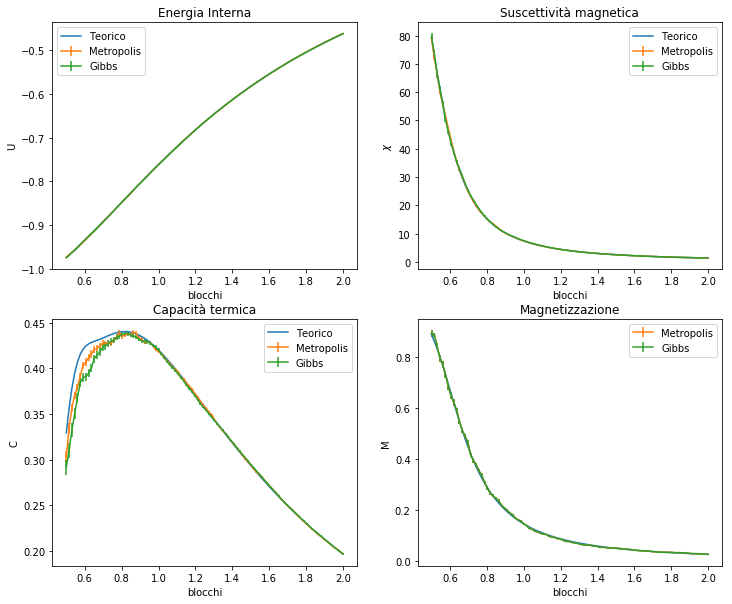

In [4]:
import matplotlib
import matplotlib.pyplot as plt
T = t
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(T, e, label="Teorico")
plt.errorbar(t,metro_energy,yerr=metro_energy_errors, label="Metropolis")
plt.errorbar(t,gibbs_energy,yerr=gibbs_energy_errors, label="Gibbs")
plt.legend()
plt.xlabel('blocchi')
plt.ylabel('U')
plt.title('Energia Interna')

plt.subplot(2,2,2)
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T, X, label="Teorico")
plt.errorbar(t,metro_chi,yerr=metro_chi_errors, label="Metropolis")
plt.errorbar(t,gibbs_chi,yerr=gibbs_chi_errors, label="Gibbs")
plt.legend()
plt.xlabel('blocchi')
plt.ylabel('$\chi$')
plt.title('Suscettività magnetica')

plt.subplot(2,2,3)
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label="Teorico")
plt.errorbar(t,metro_heat_capacity,yerr=metro_heat_capacity_errors, label="Metropolis")
plt.errorbar(t,gibbs_heat_capacity,yerr=gibbs_heat_capacity_errors, label="Gibbs")
plt.legend()
plt.xlabel('blocchi')
plt.ylabel('C')
plt.title('Capacità termica')

plt.subplot(2,2,4)
h=0.02 #external field
b = 1/T
l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T, M)
plt.errorbar(t,metro_mag,yerr=metro_mag_errors, label="Metropolis")
plt.errorbar(t,gibbs_mag,yerr=gibbs_mag_errors, label="Gibbs")
plt.legend()
plt.xlabel('blocchi')
plt.ylabel('M')
plt.title('Magnetizzazione')

plt.show()


Nei grafici ottenuti osservo un ottimo accordo tra i due metodi di campionamento e un ottimo accordo con i valori analitici esatti.